In [ ]:
import os
import math
import random
from pathlib import Path
from typing import Tuple, Optional, List, Dict

import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, ToTensor
from torchvision import transforms, utils as tv_utils
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print("Device:", DEVICE)

Device: cuda


In [ ]:
HF_DATASET_ID = "valhalla/emoji-dataset"
IMAGE_SIZE = 64
NUM_WORKERS =  2

EPOCHS = 200
LR = 2e-4
CODEBOOK_RESET_INTERVAL = 5
EMA_DECAY = 0.99

BATCH_SIZE = 128
HIDDEN_DIMS = [128, 256]
LATENT_DIM = 256
NUM_EMBEDDINGS = 512
COMMITMENT_COST = 0.25
RES_BLOCKS = 2
CHECKPOINT_PATH = "/content/vqvae_checkpoint.pt"
BEST_MODEL_PATH = "vqvae_best.pt"

In [ ]:
class HFDatasetWrapper(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.ds = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[int(idx)]
        img = item["image"]
        if self.transform:
            img = self.transform(img)
        label = item.get("text", "")
        return img, label

In [ ]:
def get_hf_dataloader(dataset_id=HF_DATASET_ID, split="train", image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True):
    print(f"Loading HuggingFace dataset `{dataset_id}` split='{split}' ...")
    hf_ds = load_dataset(dataset_id, split=split)
    print(f"Dataset loaded. Examples: {len(hf_ds)}")
    transform = Compose([
        Resize((image_size, image_size)),
        RandomHorizontalFlip(),
        ToTensor(),
    ])
    wrapped = HFDatasetWrapper(hf_ds, transform=transform)
    loader = DataLoader(wrapped, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=True)
    return loader

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm1 = nn.BatchNorm2d(channels)
        self.norm2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        x = F.relu(self.norm1(self.conv1(x)))
        x = self.norm2(self.conv2(x))
        return F.relu(x + residual)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_dims, latent_dim, num_res_blocks):
        super().__init__()
        modules = []
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, hidden_dims[0], 4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dims[0]),
            nn.ReLU()
        ))

        for i in range(len(hidden_dims) - 1):
            for _ in range(num_res_blocks):
                modules.append(ResidualBlock(hidden_dims[i]))
            modules.append(nn.Sequential(
                nn.Conv2d(hidden_dims[i], hidden_dims[i+1], 4, stride=2, padding=1),
                nn.BatchNorm2d(hidden_dims[i+1]),
                nn.ReLU()
            ))

        for _ in range(num_res_blocks):
            modules.append(ResidualBlock(hidden_dims[-1]))

        modules.append(nn.Sequential(
            nn.Conv2d(hidden_dims[-1], latent_dim, 1),
            nn.BatchNorm2d(latent_dim)
        ))

        self.encoder = nn.Sequential(*modules)

    def forward(self, x):
        return self.encoder(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dims, out_channels, num_res_blocks):
        super().__init__()
        modules = []

        modules.append(nn.Sequential(
            nn.Conv2d(latent_dim, hidden_dims[0], 1),
            nn.BatchNorm2d(hidden_dims[0]),
            nn.ReLU()
        ))
        for _ in range(num_res_blocks):
            modules.append(ResidualBlock(hidden_dims[0]))

        for i in range(len(hidden_dims) - 1):
            modules.append(nn.Sequential(
                nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i+1], 4, stride=2, padding=1),
                nn.BatchNorm2d(hidden_dims[i+1]),
                nn.ReLU()
            ))
            for _ in range(num_res_blocks):
                modules.append(ResidualBlock(hidden_dims[i+1]))

        modules.append(nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1], hidden_dims[-1] // 2, 4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dims[-1] // 2),
            nn.ReLU()
        ))

        modules.append(nn.Sequential(
            nn.Conv2d(hidden_dims[-1] // 2, out_channels, 3, padding=1),
            nn.Sigmoid()
        ))

        self.decoder = nn.Sequential(*modules)

    def forward(self, z):
        return self.decoder(z)

In [ ]:
class EMAQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay=0.99):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.decay = decay

        self.register_buffer('embedding', torch.randn(num_embeddings, embedding_dim))

        self.register_buffer('cluster_size', torch.zeros(num_embeddings))
        self.register_buffer('embedding_avg', torch.randn(num_embeddings, embedding_dim))
        self.register_buffer('code_usage_counter', torch.zeros(num_embeddings, dtype=torch.long))

    def forward(self, z):
        z_permuted = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z_permuted.view(-1, self.embedding_dim)

        distances = (torch.sum(z_flattened**2, dim=1, keepdim=True)
                    + torch.sum(self.embedding**2, dim=1)
                    - 2 * torch.matmul(z_flattened, self.embedding.t()))

        encoding_indices = torch.argmin(distances, dim=1)
        encodings = F.one_hot(encoding_indices, self.num_embeddings).float()

        quantized = torch.matmul(encodings, self.embedding).view(z_permuted.shape)

        if self.training:
            self.cluster_size.data.mul_(self.decay).add_(torch.sum(encodings, dim=0), alpha=1 - self.decay)
            self.embedding_avg.data.mul_(self.decay).add_(torch.matmul(encodings.t(), z_flattened), alpha=1 - self.decay)

            n = torch.sum(self.cluster_size)
            cluster_size_smooth = (self.cluster_size + 1e-5) / (n + self.num_embeddings * 1e-5) * n

            self.embedding.data.copy_(self.embedding_avg / cluster_size_smooth.unsqueeze(1))

            unique, counts = torch.unique(encoding_indices, return_counts=True)
            self.code_usage_counter[unique] += counts

        e_latent_loss = F.mse_loss(quantized.detach(), z_permuted)
        loss = self.commitment_cost * e_latent_loss

        quantized = z_permuted + (quantized - z_permuted).detach()
        quantized = quantized.permute(0, 3, 1, 2).contiguous()

        avg_probs = torch.mean(encodings, dim=0)

        return quantized, loss, encoding_indices.view(z.shape[0], z.shape[2], z.shape[3])

    def reset_unused_codes(self, batch_latents):
        unused_indices = torch.where(self.code_usage_counter == 0)[0]
        if len(unused_indices) == 0:
            return

        print(f"Resetting {len(unused_indices)} unused codebook vectors.")

        z_flattened = batch_latents.permute(0, 2, 3, 1).contiguous().view(-1, self.embedding_dim)
        random_latents = z_flattened[torch.randint(0, z_flattened.size(0), (len(unused_indices),))]

        self.embedding.data[unused_indices] = random_latents
        self.cluster_size.data[unused_indices] = 1.0
        self.embedding_avg.data[unused_indices] = random_latents

        self.code_usage_counter.zero_()

    def code_usage_percentage(self):
        used_codes = torch.sum(self.code_usage_counter > 0).item()
        return (used_codes / self.num_embeddings) * 100.0


In [ ]:
class VQVAE(nn.Module):
    def __init__(self, in_channels, hidden_dims, latent_dim, num_embeddings, commitment_cost, num_res_blocks, ema_decay):
        super().__init__()
        self.encoder = Encoder(in_channels, hidden_dims, latent_dim, num_res_blocks)
        self.vq = EMAQuantizer(num_embeddings, latent_dim, commitment_cost, decay=ema_decay)
        self.decoder = Decoder(latent_dim, list(reversed(hidden_dims)), in_channels, num_res_blocks)

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss, indices = self.vq(z)
        reconstructed = self.decoder(quantized)
        return reconstructed, vq_loss, indices

In [ ]:
def show_image_tensor_grid(tensor_batch, ncols=8, title=None):
    grid = tv_utils.make_grid(tensor_batch.detach().cpu(), nrow=ncols, pad_value=1.0)
    npimg = grid.numpy().transpose(1,2,0)
    plt.figure(figsize=(10, 10 * (grid.shape[1] / grid.shape[2])))
    plt.axis("off")
    if title:
        plt.title(title)
    plt.imshow(npimg)
    plt.show()

def visualize_reconstructions(model: VQVAE, dataloader: DataLoader, n=8, device=DEVICE):
    model.eval()
    dataset = dataloader.dataset
    indices = random.sample(range(len(dataset)), n)
    imgs = torch.stack([dataset[i][0] for i in indices]).to(device)
    with torch.no_grad():
        recon, _, indices = model(imgs)
    stacked = torch.cat([imgs.cpu(), recon.cpu()], dim=0)
    show_image_tensor_grid(stacked, ncols=n, title="Top row: Original | Bottom row: Reconstruction")

In [ ]:
train_loader = get_hf_dataloader(
        dataset_id="valhalla/emoji-dataset",
        split="train",
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS
    )

Loading HuggingFace dataset `valhalla/emoji-dataset` split='train' ...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dataset_infos.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

data/train-00000-of-00001-38cc4fa96c139e(…):   0%|          | 0.00/139M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2749 [00:00<?, ? examples/s]

Dataset loaded. Examples: 2749


In [ ]:
vq_vae_model = VQVAE(
        in_channels=3,
        hidden_dims=HIDDEN_DIMS,
        latent_dim=LATENT_DIM,
        num_embeddings=NUM_EMBEDDINGS,
        commitment_cost=COMMITMENT_COST,
        num_res_blocks=RES_BLOCKS,
        ema_decay=EMA_DECAY
    ).to(DEVICE)

In [ ]:
checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)

In [ ]:
vq_vae_model.load_state_dict(checkpoint["model_state"])
vq_vae_model.vq.embedding.data = checkpoint["quantizer"].to(DEVICE)

In [ ]:
print("Codebook shape:", vq_vae_model.vq.embedding.shape)
print("Model parameters loaded successfully.")

Codebook shape: torch.Size([512, 256])
Model parameters loaded successfully.


In [ ]:
def show_image_tensor_grid(tensor_batch, ncols=8, title=None):
    grid = tv_utils.make_grid(tensor_batch.detach().cpu(), nrow=ncols, pad_value=1.0)
    npimg = grid.numpy().transpose(1,2,0)
    plt.figure(figsize=(10, 10 * (grid.shape[1] / grid.shape[2])))
    plt.axis("off")
    if title:
        plt.title(title)
    plt.imshow(npimg)
    plt.show()

def visualize_reconstructions(model: VQVAE, dataloader: DataLoader, n=8, device=DEVICE):
    model.eval()
    dataset = dataloader.dataset
    indices = random.sample(range(len(dataset)), n)
    imgs = torch.stack([dataset[i][0] for i in indices]).to(device)
    with torch.no_grad():
        recon, _, indices = model(imgs)
    stacked = torch.cat([imgs.cpu(), recon.cpu()], dim=0)
    show_image_tensor_grid(stacked, ncols=n, title="Top row: Original | Bottom row: Reconstruction")

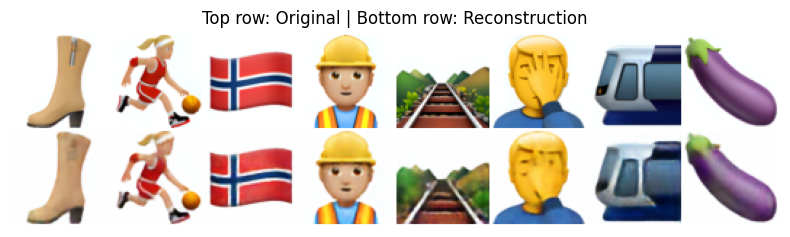

In [ ]:
visualize_reconstructions(vq_vae_model, train_loader, n=8)

# Task C
Morph between the emojis "smiling face with smiling eyes" and "smiling face with heart shaped eyes" in latent space using 20, 10, and 5 interpolation steps, and visualize the transitions.

## Select specific latent vectors



In [ ]:
vq_vae_model.eval()

def find_image_by_label(dataloader, label_substrings, device):
    for images, labels in dataloader:
        for i, label in enumerate(labels):
            if any(substring.lower() in label.lower() for substring in label_substrings):
                print(f"Found image with label: {label}")
                return images[i].unsqueeze(0).to(device)
    return None

smile_eyes_img = find_image_by_label(train_loader, ["smiling face with smiling eyes"], DEVICE)
heart_eyes_img = find_image_by_label(train_loader, ["smiling face with heart shaped eyes"], DEVICE)

if smile_eyes_img is None:
    print("Could not find 'smiling face with smiling eyes' emoji in the dataset.")
elif heart_eyes_img is None:
    print("Could not find 'smiling face with heart shaped eyes' emoji in the dataset.")
else:
    print("Smiling face with smiling eyes image shape:", smile_eyes_img.shape)
    print("Smiling face with heart shaped eyes image shape:", heart_eyes_img.shape)

    with torch.no_grad():
        latent1 = vq_vae_model.encoder(smile_eyes_img)
        latent2 = vq_vae_model.encoder(heart_eyes_img)

    print("Latent representation 1 shape:", latent1.shape)
    print("Latent representation 2 shape:", latent2.shape)

Found image with label: smiling face with smiling eyes and three hearts
Found image with label: smiling face with heart shaped eyes
Smiling face with smiling eyes image shape: torch.Size([1, 3, 64, 64])
Smiling face with heart shaped eyes image shape: torch.Size([1, 3, 64, 64])
Latent representation 1 shape: torch.Size([1, 256, 16, 16])
Latent representation 2 shape: torch.Size([1, 256, 16, 16])


In [ ]:
interpolation_steps_list = [20, 10, 5]
print(interpolation_steps_list)

[20, 10, 5]



Generating 20 interpolation steps:
Shape of stacked decoded images: torch.Size([20, 3, 64, 64])


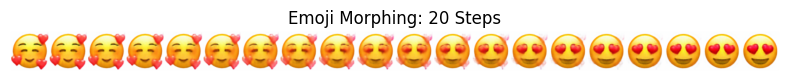


Generating 10 interpolation steps:
Shape of stacked decoded images: torch.Size([10, 3, 64, 64])


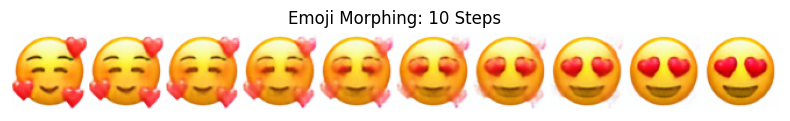


Generating 5 interpolation steps:
Shape of stacked decoded images: torch.Size([5, 3, 64, 64])


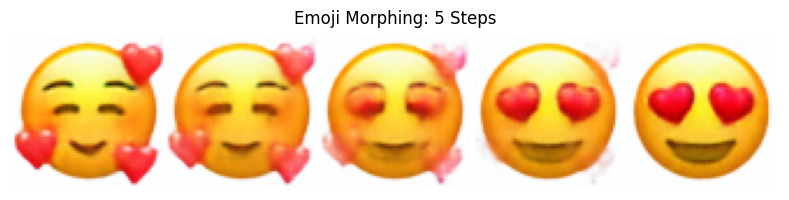

In [ ]:
vq_vae_model.eval()

for num_interpolation_steps in interpolation_steps_list:
    print(f"\nGenerating {num_interpolation_steps} interpolation steps:")
    interpolated_latents = []
    for i in range(num_interpolation_steps):
        t = i / (num_interpolation_steps - 1)
        interpolated_latent = (1 - t) * latent1 + t * latent2
        interpolated_latents.append(interpolated_latent)

    decoded_images = []
    with torch.no_grad():
        for latent in interpolated_latents:
            decoded_image = vq_vae_model.decoder(latent)
            decoded_images.append(decoded_image)

    decoded_images_tensor = torch.cat(decoded_images, dim=0)
    print("Shape of stacked decoded images:", decoded_images_tensor.shape)

    show_image_tensor_grid(decoded_images_tensor, ncols=num_interpolation_steps, title=f"Emoji Morphing: {num_interpolation_steps} Steps")
